## Setup imports

In [1]:
# install spleen dataset (https://drive.google.com/file/d/1dxRiLfJKD_he9a6mLFl2mzGzdKvq2ocn/view)
%pip install gdown
import gdown

!gdown --id '1dxRiLfJKD_he9a6mLFl2mzGzdKvq2ocn'

In [2]:
# unzip dataset
!mkdir -p SpleenDataset
!unzip SpleenDataset.zip -d SpleenDataset 

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [1]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

## Set train/validation/test data filepath

In [2]:
data_dir = os.path.join("./", "SpleenDataset")
train_images = sorted(glob.glob(os.path.join(data_dir, "train/image", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "train/mask", "*.nii.gz")))
train_data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]

val_images = sorted(glob.glob(os.path.join(data_dir, "val/image", "*.nii.gz")))
val_labels = sorted(glob.glob(os.path.join(data_dir, "val/mask", "*.nii.gz")))
val_data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(val_images, val_labels)]

test_images = sorted(glob.glob(os.path.join(data_dir,"test/image", "*.nii.gz")))
test_labels = sorted(glob.glob(os.path.join(data_dir,"test/mask", "*.nii.gz")))
test_data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(test_images, test_labels)]

In [3]:
train_files, val_files, test_files = train_data_dicts, val_data_dicts, test_data_dicts

## Setup data augmentation

For data augmentation, here are the basic requirements:

1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `ScaleIntensityRanged` clips the CT's data format, HU value, into a certain range (-57,164) and normalize it to (0,1)
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.

You can try more data augmentation techniques to further improve the performance.

In [5]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

/home/jamesyoung/.local/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [7]:
import os
from torch.utils.data import Dataset
from monai.data import DataLoader


class CT_Dataset(Dataset):
    def __init__(self, dataset_path, transform=None,split='test'):
        self.dataset_path = dataset_path
        self.transform = transform
        self.split = split

    def __len__(self):
        return len(self.dataset_path)

    def __getitem__(self, idx):
        data = self.dataset_path[idx]
        if self.transform:
            data = self.transform(data)
        return data

# here we don't cache any data in case out of memory issue
train_ds = CT_Dataset(train_files, train_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CT_Dataset(val_files,val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4)

test_ds = CT_Dataset(test_files, val_transforms)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=4)

In [26]:
test_ds = CT_Dataset(test_files, val_transforms)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=4)

# Implement a 3D UNet for segmentation task

We give a possible network structure here, and you can modify it for a stronger performance.

In the block ```double_conv```, you can implement the following structure：

| Layer |
|-------|
| Conv3d |
| BatchNorm3d |
| PReLU |
| Conv3d |
| BatchNorm3d |
| PReLU |


In the overall UNet structure, you can implement the following structure. ```conv_down``` and ```conv_up``` refers to the function block you defined above.

| Layer | Input Channel | Output Channel |
|-------|-------------|--------------|
| conv_down1 | 1 | 16 |
| maxpool | 16 | 16 |
| conv_down2 | 16 | 32 |
| maxpool | 32 | 32 |
| conv_down3 | 32 | 64 |
| maxpool | 64 | 64 |
| conv_down4 | 64 | 128 |
| maxpool | 128 | 128 |
| conv_down5 | 128 | 256 |
| upsample | 256 | 256 |
| conv_up4 | 128+256 | 128 |
| upsample | 128 | 128 |
| conv_up3 | 64+128 | 64 |
| upsample | 64 | 32 |
| conv_up4 | 32+64 | 32 |
| upsample | 32 | 32 |
| conv_up4 | 16+32 | 16 |
| conv_out | 16 | 2 |


In [9]:
import torch
import torch.nn as nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm3d(out_channels),
        nn.PReLU(),
        nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm3d(out_channels),
        nn.PReLU()
    )

class UNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv_down1 = double_conv(1, 16)
        self.conv_down2 = double_conv(16, 32)
        self.conv_down3 = double_conv(32, 64)
        self.conv_down4 = double_conv(64, 128)
        self.conv_down5 = double_conv(128, 256)

        self.upsample = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        self.conv_up4 = double_conv(128+256, 128)
        self.conv_up3 = double_conv(64+128, 64)
        self.conv_up2 = double_conv(32+64, 32)
        self.conv_up1 = double_conv(16+32, 16)
        
        self.conv_out = nn.Conv3d(16, 2, kernel_size=1)
        
    def forward(self, x):
        enc1 = self.conv_down1(x)
        pool1 = nn.MaxPool3d(kernel_size=2)(enc1)
        enc2 = self.conv_down2(pool1)
        pool2 = nn.MaxPool3d(kernel_size=2)(enc2)
        enc3 = self.conv_down3(pool2)
        pool3 = nn.MaxPool3d(kernel_size=2)(enc3)
        enc4 = self.conv_down4(pool3)
        pool4 = nn.MaxPool3d(kernel_size=2)(enc4)
        enc5 = self.conv_down5(pool4)
        
        out = self.upsample(enc5)
        dec4 = self.conv_up4(torch.cat([enc4, out], dim=1))
        up4 = self.upsample(dec4)
        dec3 = self.conv_up3(torch.cat([enc3, up4], dim=1))
        up3 = self.upsample(dec3)
        dec2 = self.conv_up2(torch.cat([enc2, up3], dim=1))
        up2 = self.upsample(dec2)
        dec1 = self.conv_up1(torch.cat([enc1, up2], dim=1))
        
        # Final convolution
        output = self.conv_out(dec1)
        
        return output

## Create Model, Loss, Optimizer

In [17]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = UNet().to(device) # define your model here
from monai.networks.nets import UNet
model = UNet(spatial_dims=3, in_channels=1, out_channels=2, channels=(16, 32, 64, 128, 256), strides=(2, 2, 2, 2), num_res_units=2, norm=Norm.BATCH,).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True) # define your loss function here
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")# define your metric here

print(f'Using {device}')

Using cuda


## Define your training/val/test loop

### Tensorboard Setup

In [66]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [20]:
# free gpu mem
import gc
import torch

def gpu_mem_restore():
    gc.collect()
    torch.cuda.empty_cache()

gpu_mem_restore()

In [22]:
max_epochs = 300
val_interval = 2
best_metric = -1
best_metric_epoch = -1
train_loss_values = []
val_loss_values = []
train_metric_values = []
val_metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])


for epoch in range(max_epochs):
    # the steps are similar to HW1. Please pay attention to the difference in the segmentation task.
    # gpu_mem_restore()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    train_epoch_loss = 0
    step = 0
    for train_data in train_loader:
        # fetch data
        train_inputs, train_labels = (
            train_data["image"].to(device),
            train_data["label"].to(device),
        )
        # set gradients to 0
        optimizer.zero_grad()
        # feed forward, loss, backpropagation, step
        outputs = model(train_inputs)
        loss = loss_function(outputs, train_labels)
        loss.backward()
        step += 1
        optimizer.step()
        # record the loss
        train_epoch_loss += loss.item()
        # compute metric for current iteration
        outputs = [post_pred(i) for i in decollate_batch(outputs)]
        train_labels = [post_label(i) for i in decollate_batch(train_labels)]
        dice_metric(y_pred=outputs, y=train_labels)



    # record training dice
    train_metric = dice_metric.aggregate().item()
    dice_metric.reset()
    train_metric_values.append(train_metric)
    writer.add_scalar("train/loss", train_epoch_loss, epoch)
    # record training loss
    train_epoch_loss /= step
    train_loss_values.append(train_epoch_loss)
    writer.add_scalar("train/dice", train_metric, epoch)

    print(f"Train Loss: {train_epoch_loss:.4f}, Train Dice: {train_metric:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_epoch_loss = 0
        val_step = 0
        with torch.no_grad():
            for val_data in val_loader:
                val_step += 1
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                # calculate loss
                loss = loss_function(val_outputs, val_labels)
                val_epoch_loss += loss.item()
                # compute metric for current iteration
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                dice_metric(y_pred=val_outputs, y=val_labels)

            # record loss
            val_epoch_loss /= val_step
            writer.add_scalar("val/loss", val_epoch_loss, epoch)
            val_loss_values.append(val_epoch_loss)

            # record dice metric
            val_metric = dice_metric.aggregate().item()
            dice_metric.reset()
            val_metric_values.append(val_metric)
            writer.add_scalar("val/dice", val_metric, epoch)

            print(f"Val Loss: {val_epoch_loss:.4f}, Val Dice: {val_metric:.4f}")

            # save best model
            if val_metric > best_metric:
                best_metric = val_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join("./", "best_checkpoint_spleen.pth"))
                print("Saved new best metric model")
            print(f"\nBest mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}")

print(f"best_metric: {best_metric:.4f} " f"at epoch {best_metric_epoch}")

----------
epoch 1/300
Train Loss: 0.3859, Train Dice: 0.8498
----------
epoch 2/300
Train Loss: 0.3784, Train Dice: 0.8467
Val Loss: 0.5661, Val Dice: 0.0845
Saved new best metric model

Best mean dice: 0.0845 at epoch: 2
----------
epoch 3/300
Train Loss: 0.3772, Train Dice: 0.8475
----------
epoch 4/300
Train Loss: 0.3740, Train Dice: 0.8506
Val Loss: 0.5625, Val Dice: 0.0891
Saved new best metric model

Best mean dice: 0.0891 at epoch: 4
----------
epoch 5/300
Train Loss: 0.3743, Train Dice: 0.8590
----------
epoch 6/300
Train Loss: 0.3702, Train Dice: 0.8612
Val Loss: 0.5692, Val Dice: 0.0658

Best mean dice: 0.0891 at epoch: 4
----------
epoch 7/300
Train Loss: 0.3657, Train Dice: 0.8646
----------
epoch 8/300
Train Loss: 0.3593, Train Dice: 0.8652
Val Loss: 0.5469, Val Dice: 0.1001
Saved new best metric model

Best mean dice: 0.1001 at epoch: 8
----------
epoch 9/300
Train Loss: 0.3564, Train Dice: 0.8642
----------
epoch 10/300
Train Loss: 0.3611, Train Dice: 0.8692
Val Loss: 0

In [32]:
# tensorboard
writer.flush()
writer.close()

# open with tensorboard --logdir=runs

## Inference and Report performance on Test Set

In [56]:
from sklearn.metrics import jaccard_score
from torchmetrics import JaccardIndex
from monai.metrics import SurfaceDistanceMetric, HausdorffDistanceMetric, MeanIoU
import numpy as np

In [57]:
# metrics
iou_metric = MeanIoU(include_background=False, reduction="mean")
hd95_metric = HausdorffDistanceMetric(include_background=True, percentile=95, reduction="mean") 
asd_metric = SurfaceDistanceMetric(include_background=True, symmetric=True, reduction="mean")

# testing
model.load_state_dict(torch.load("best_checkpoint_spleen.pth"))
model.eval()
with torch.no_grad():
    for test_data in test_loader:
        test_inputs, test_labels = (
            test_data["image"].to(device),
            test_data["label"].to(device),
        )
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_outputs = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model)
        test_outputs = [post_pred(i) for i in decollate_batch(test_outputs)]
        test_labels = [post_label(i) for i in decollate_batch(test_labels)]
        # compute metrics
        dice_metric(y_pred=test_outputs, y=test_labels)
        iou_metric(test_outputs, test_labels)
        hd95_metric(test_outputs, test_labels)
        asd_metric(test_outputs, test_labels)

    # calculate metric
    metric = dice_metric.aggregate().item()
    jaccard_metric = iou_metric.aggregate().item()
    hd_metric = hd95_metric.aggregate().item()
    asd = asd_metric.aggregate().item()
    dice_metric.reset()
    print(f"Test dice metric score: {metric * 100:.4f}% Test Jaccard score: {jaccard_metric:.4f}\nTest Hausdorff Distance: {hd_metric:.4f} Test ASD: {asd:.4f}")

Test dice metric score: 83.3284% Test Jaccard score: 0.7130
Test Hausdorff Distance: 26.5569 Test Surface Distance: 3.7163


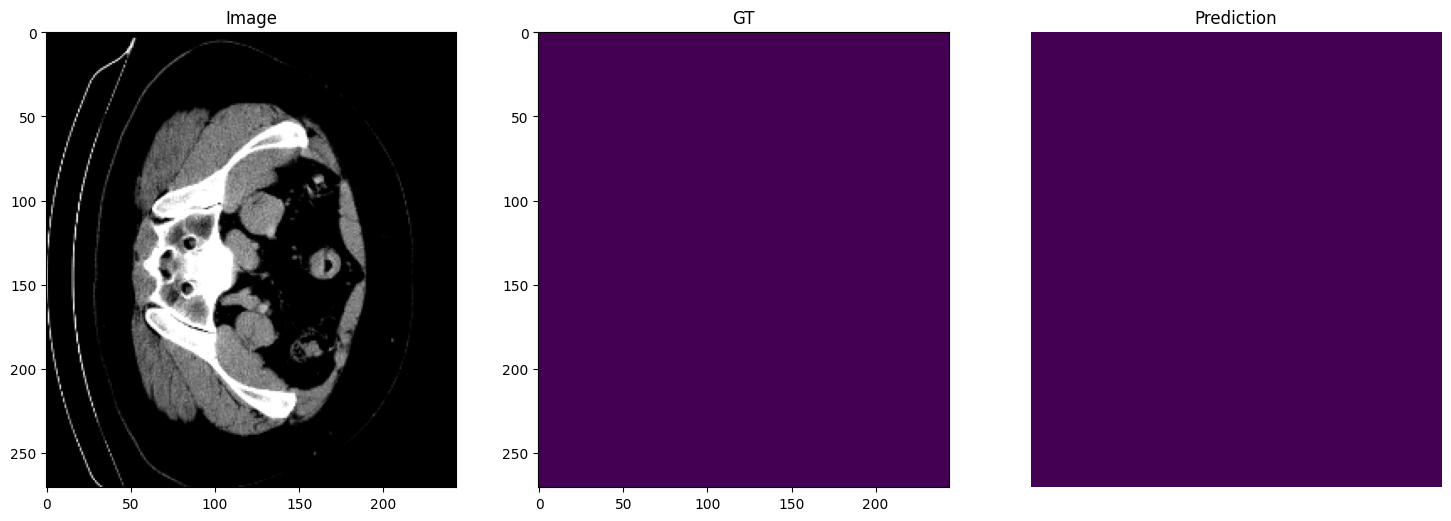

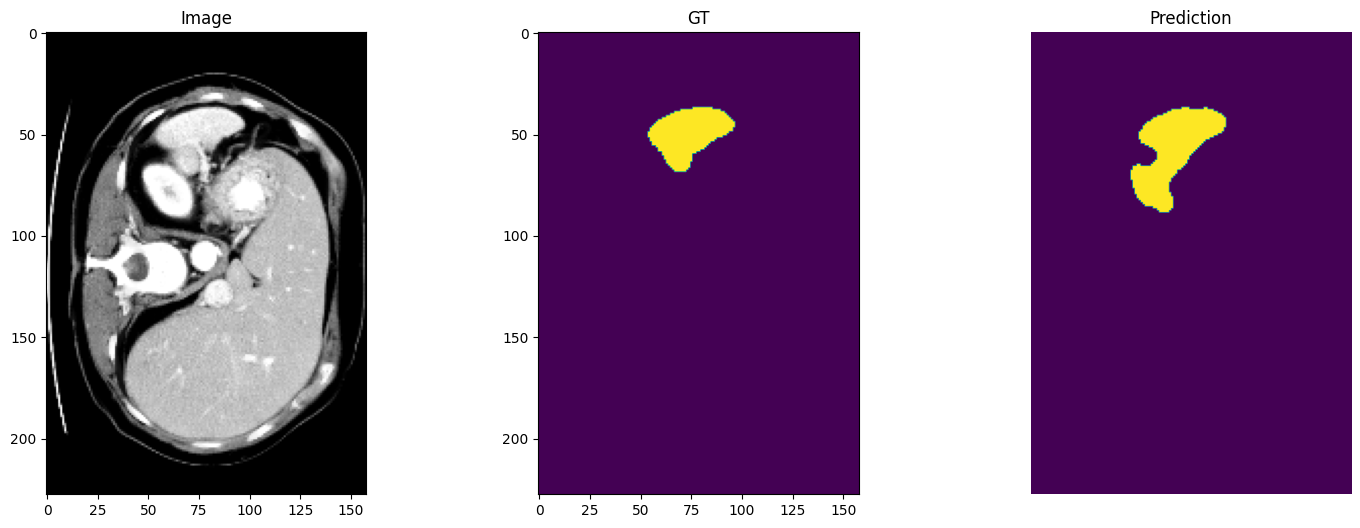

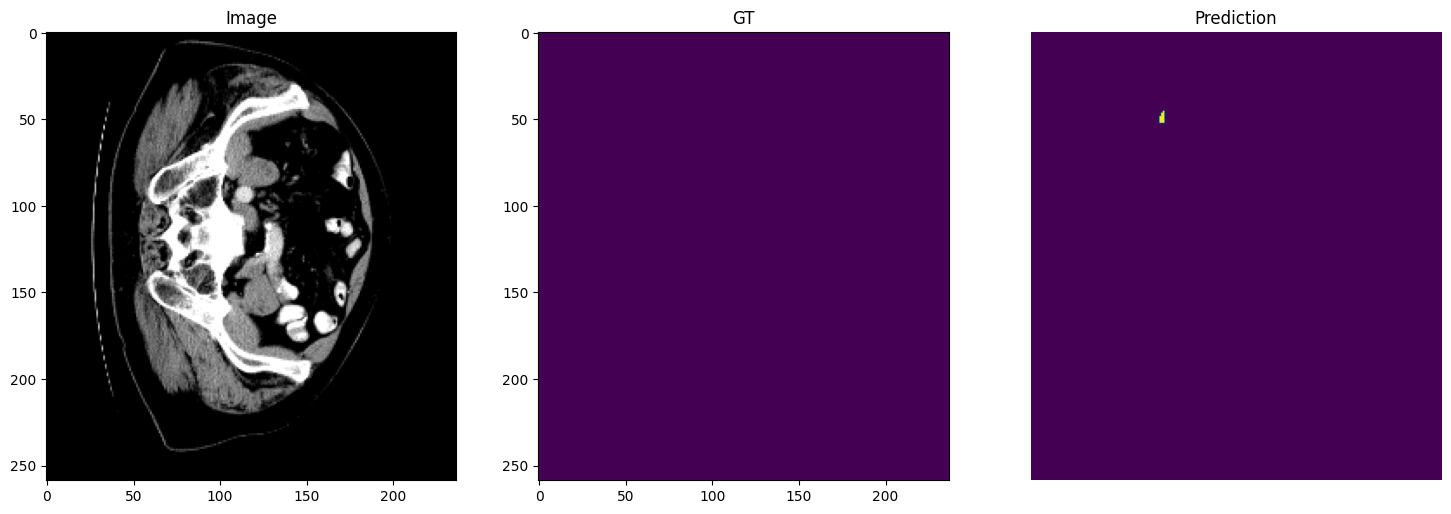

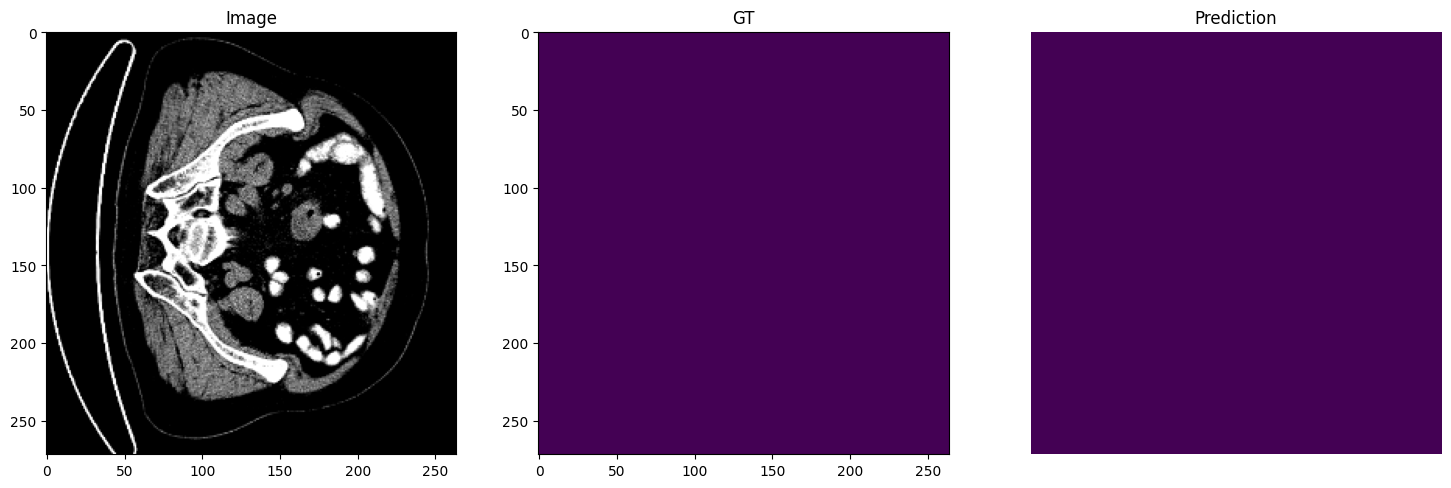

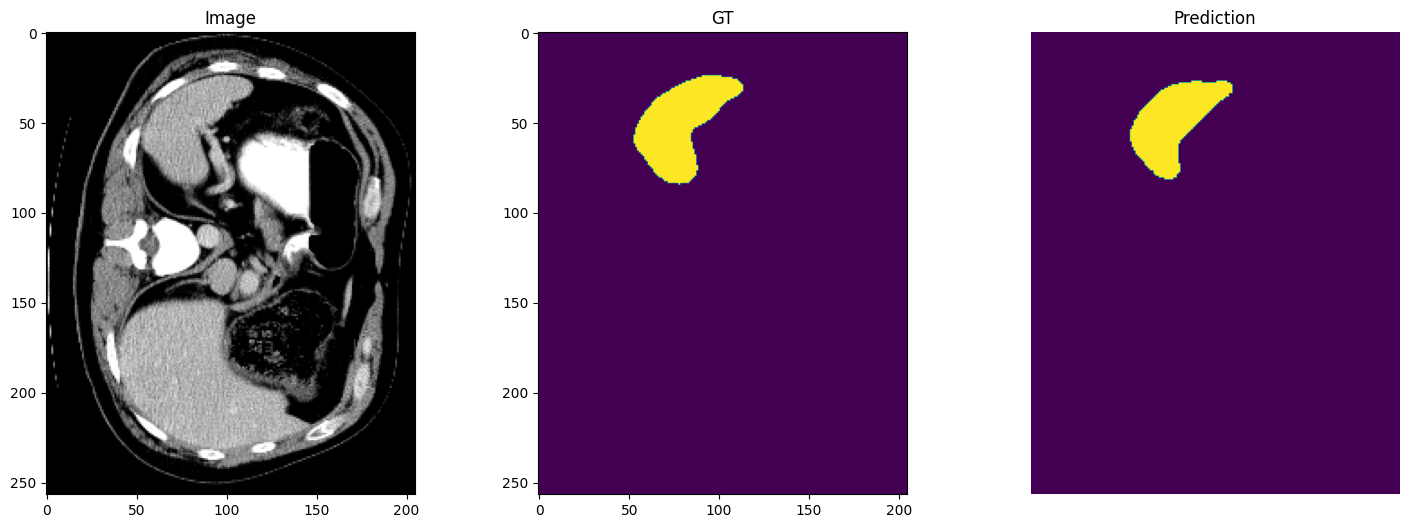

In [65]:
# display 4 images

model.load_state_dict(torch.load("best_checkpoint_spleen.pth"))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(test_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"Image")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"GT")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"Prediction")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.axis('off')
        plt.show()
        if i == 4:
            break